In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd

extracted_features_dir = "../data/extracted_features/"
results_dir = "../data/results/"
sentiment_dir = "../data/evaluationscore/"
canonization_labels_dir = "../data/labels/"
lang = "ger"

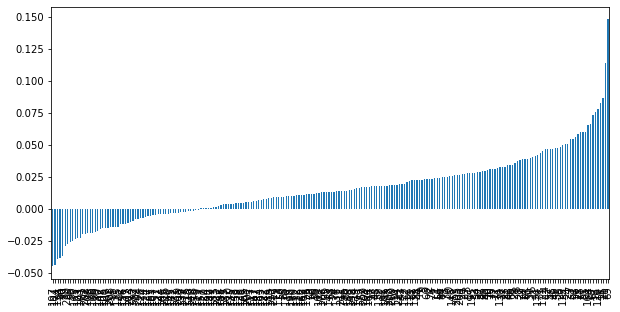

In [2]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, SVC
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBRegressor
from copy import deepcopy
from scipy.stats import pearsonr
from utils import read_sentiment_scores, read_library_scores, read_sentiart_textblob_scores
from math import sqrt
get_ipython().run_line_magic("matplotlib", "inline") # %matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import statistics
import random
random.seed(9)

labels = read_sentiment_scores(sentiment_dir, canonization_labels_dir, lang)
library_scores = read_library_scores(sentiment_dir, canonization_labels_dir, lang)
labels = read_sentiart_textblob_scores(sentiment_dir, canonization_labels_dir, lang)

In [3]:
senti_tool = "sentiment_Textblob"
labels = labels[["book_name","sentiment_Textblob"]]
labels = labels.rename(columns={"sentiment_Textblob": "y"})

In [4]:
labels

,book_name,y
0,Alexis_Willibald_Der-falsche-Woldemar_1842,0.025530
1,Alexis_Willibald_Ruhe-ist-die-erste-Buergerpfl...,0.023794
2,Alexis_Willibald_Der-Roland-von-Berlin_1840,-0.034293
3,Alexis_Willibald_Cabanis_1830,0.023481
4,Alexis_Willibald_Schloss-Avalon_1826,0.027773
...,...,...
213,Wienbarg_Ludolph_Aesthetische-Feldzuege_1834,0.018264
215,Willkomm_Ernst_Weisse-Sclaven_1845,0.005779
217,Wobeser_Wilhelmine-Caroline_Elisa-oder-das-Wei...,0.016523
219,Zschokke_Johann_Das-Goldmacherdorf_1817,-0.002568


176


<AxesSubplot:ylabel='Frequency'>

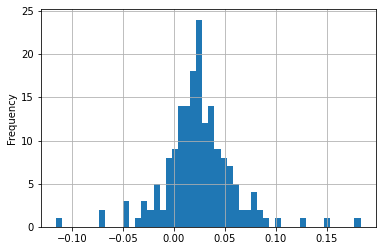

In [5]:
## Labels statistics
print(len(pd.unique(labels["book_name"]))) #197
# 254 labels, 197 different book_names -> 57 second/third... reviews
# 36 book_names with more than 1 label, these 36 book_names have 93 labels
# 93 = 36 first reviews + 57 second/third... reviews
# 6 texts have opposing reviews (13 reviews are opposing)
# 191 texts after aggregating (without opposing reviews)

labels["y"].plot.hist(grid=True, bins=50)

In [6]:
class Regression(object):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        assert isinstance(drop_columns_including, list)
        for i in drop_columns_including:
            assert isinstance(i, str)
        assert (dimensionality_reduction in ["k_best_f_reg_0_10", "k_best_mutual_info_0_10", "ss_pca_0_95"]) or (dimensionality_reduction is None)
        self._check_class_specific_assertions()
        
        self.language = language
        self.features = features
        self.labels = labels
        self.labels = self._prepare_labels()
        self.drop_columns_including = drop_columns_including
        self.dimensionality_reduction = dimensionality_reduction
        self.model_param = model_param
        self.model = model
        self.verbose = verbose

        if self.features == "book":
            self.df = deepcopy(book_df)
        elif self.features == "chunk":
            self.df = deepcopy(chunk_df)
        elif self.features == "chunk_and_copied_book":
            self.df = deepcopy(chunk_and_copied_book_df)
        elif self.features == "book_and_averaged_chunk":
            self.df = deepcopy(book_and_averaged_chunk_df)

        columns_before_drop = set(self.df.columns)
        if self.drop_columns_including:
            self.df = self.df[[column for column in self.df.columns if not self._drop_column(column)]].reset_index(drop=True)
        columns_after_drop = set(self.df.columns)
        if self.verbose:
            print(f"Dropped {len(columns_before_drop - columns_after_drop)} columns.")
            
    def _check_class_specific_assertions(self):
        assert model in ["xgboost", "svr", "lasso"]
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
    
    def _prepare_labels(self):
        if "c" in self.labels.columns: 
            labels = self.labels.drop(columns="c")
        else:
            labels = self.labels
        return labels

    def _drop_column(self, column):
        for string in self.drop_columns_including:
            if string in column:
                return True
        return False
    
    def _custom_pca(self, train_X):
        for i in range(5, train_X.shape[1], int((train_X.shape[1] - 5) / 10)):
            pca = PCA(n_components=i)
            new_train_X = pca.fit_transform(train_X)
            if pca.explained_variance_ratio_.sum() >= 0.95:
                break
        return new_train_X, pca

    def _select_features(self, train_X, train_y, validation_X):
        if self.dimensionality_reduction == "ss_pca_0_95":
            ss = StandardScaler()
            train_X = ss.fit_transform(train_X)
            validation_X = ss.transform(validation_X)
            train_X, pca = self._custom_pca(train_X)
            validation_X = pca.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_f_reg_0_10":
            k_best = SelectKBest(f_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_mutual_info_0_10":
            k_best = SelectKBest(mutual_info_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction is None:
            pass
        return train_X, validation_X
    
    def _impute(self, train_X, validation_X):
        imputer = KNNImputer()
        train_X = imputer.fit_transform(train_X)
        validation_X = imputer.transform(validation_X)
        return train_X, validation_X
    
    def _get_model(self, model_param, train_X=None, train_y=None, train_book_names=None, task_type=None):
        if self.model == "xgboost":
            if task_type == "binary_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1], y=train_y.astype(int).tolist())))
            elif task_type == "multiclass_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
            elif task_type == "regression":
                is_classification = False
            else:
                raise Exception("Not a valid task_type")
            
            def feval(preds, train_data):
                labels = train_data.get_label()
                if is_classification:
                    labels = labels.astype(int)
                    preds = preds.argmax(axis=1).astype(int)
                    if task_type == "binary_classification":
                        return 'acc', accuracy_score(labels, preds)
                    elif task_type == "multiclass_classification":
                        return 'f1', f1_score(labels, preds, average='macro')
                else:
                    return 'rmse', np.sqrt(mean_squared_error(labels, preds))
            
            if is_classification:
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
            else:
                dtrain = xgboost.DMatrix(train_X, label=train_y)
            results = []
            df = np.hstack((train_book_names, train_X))
            df = pd.DataFrame(df, columns=["book_name"] + [f"col_{i}" for i in range(train_X.shape[1])])
            for max_depth in [2, 4, 6, 8]:
                for learning_rate in [None, 0.01, 0.033, 0.1]:
                    for colsample_bytree in [0.33, 0.60, 0.75]:
                        if task_type == "multiclass_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"}
                        elif task_type == "binary_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"}
                        elif task_type == "regression":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1}
                        else:
                            raise Exception("Not a valid task_type")
                        cv_results = xgboost.cv(
                                        params,
                                        dtrain,
                                        num_boost_round=99999,
                                        seed=42,
                                        nfold=5,
                                        folds=self._split_booknames(df, 5, return_indices=True),
                                        feval=feval,
                                        maximize=is_classification, # if classification, maximize f1/acc score.
                                        early_stopping_rounds=10,
                                        verbose_eval=False)

                        if task_type == "binary_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-acc-mean"]
                        elif task_type == "multiclass_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-f1-mean"]
                        elif task_type == "regression":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-rmse-mean"]
                        else:
                            raise Exception("Not a valid task_type")
                        num_boost_round = len(cv_results)
                        if task_type == "multiclass_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"})
                        elif task_type == "binary_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"})
                        elif task_type == "regression":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score})
                        else:
                            raise Exception("Not a valid task_type")
            best_parameters = sorted(results, key=lambda x: x["nested_cv_score"], reverse=is_classification)[0]
            return best_parameters
        elif self.model == "svr":
            return SVR(C=model_param)
        elif self.model == "lasso":
            return Lasso(alpha=model_param)
        elif self.model == "svc":
            return SVC(C=model_param)
        
    def _split_booknames(self, df, nr_splits, return_indices=False):
        """
        Distribute book names over splits.
        All works of an author are in the same split.
        """
        book_names = df["book_name"].unique()
        authors = []
        booknames_authors_mapping = {}

        #Get authors
        for book_name in book_names:
            author = "_".join(book_name.split("_")[:2])
            authors.append(author)
            if author in booknames_authors_mapping:
                booknames_authors_mapping[author].append(book_name)
            else:
                booknames_authors_mapping[author] = []
                booknames_authors_mapping[author].append(book_name)
        #Distribute authors over splits so that each split has approximately the same number of books
        works_per_author = Counter(authors)
        goal_sum = round(len(book_names)/nr_splits)
        tolerance = 0.03
        lower_threshold = goal_sum - round(tolerance*goal_sum)
        upper_threshold = goal_sum + round(tolerance*goal_sum)
        author_splits = []
        popped_dict = {}

        for i in range (0, nr_splits-1):
            works_in_split = 0
            split = []
            curr_author_workcount = 0

            # take values from popped dict first
            if bool(popped_dict):  
                popped = []
                for curr_author, curr_author_workcount in popped_dict.items():
                    # leave item in popped dict if value is too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        continue
                    else:
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                for current_author in popped:
                    del popped_dict[current_author]
            while works_in_split < upper_threshold:
                if bool(works_per_author):
                    curr_author = random.choice(list(works_per_author.keys()))
                    curr_author_workcount = works_per_author.pop(curr_author)
                    # Put values into separate dict if too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        popped_dict[curr_author] = curr_author_workcount
                    else:
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                else:
                    #ignore upper threshold
                    popped = []
                    for curr_author, curr_author_workcount in popped_dict.items():
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                    for current_author in popped:
                        del popped_dict[current_author]

            author_splits.append(split)
        #Create last split directly from remaining dict
        works_in_last_split = sum(works_per_author.values()) + sum(popped_dict.values())
        split = list(works_per_author.keys()) + list(popped_dict.keys())
        author_splits.append(split)

        if not return_indices:
            #Map author splits to book names
            book_splits = []
            for author_split in author_splits:
                book_split = []
                for author in author_split:
                    book_split.extend(booknames_authors_mapping[author])
                book_splits.append(book_split)
        else:
            book_name_idx_mapping = dict((book_name, index) for index, book_name in enumerate(book_names))
            book_splits = []
            for author_split in author_splits:
                test_split = []
                for author in author_split:
                    test_split.extend([book_name_idx_mapping[book_name] for book_name in booknames_authors_mapping[author]])
                train_split = list(set(book_name_idx_mapping.values()) - set(test_split))
                book_splits.append((train_split, test_split))
        return book_splits
    
    def _get_pvalue(self, validation_corr_pvalues):
        # Harmonic mean p-value
        denominator = sum([1/x for x in validation_corr_pvalues])
        mean_p_value = len(validation_corr_pvalues)/denominator
        return mean_p_value
    
    def _combine_df_labels(self, df):
        #Average of sentiscores per book
        df = df.merge(right=self.labels, on="book_name", how="inner", validate="many_to_one")
        return df
    
    def run(self):
        all_predictions = []
        all_labels = []

        train_mses = []
        train_maes = []
        train_r2s = []
        train_corrs = []
        
        validation_mses = []
        validation_maes = []
        validation_r2s = []
        validation_corrs = []
        validation_corr_pvalues = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = self._split_booknames(df, 5)
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="regression")
                dtrain = xgboost.DMatrix(train_X, label=train_y)
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
                
                print("train preds:", model.predict(xgboost.DMatrix(train_X)))
                print("validation preds:", model.predict(xgboost.DMatrix(validation_X)))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)
            
            train_books = train_books.groupby("book_name").mean()
            validation_books = validation_books.groupby("book_name").mean()
            all_validation_books.append(validation_books.reset_index())
            
            train_y = train_books["y"].tolist()
            train_yhat = train_books["yhat"].tolist()
            validation_y = validation_books["y"].tolist()
            validation_yhat = validation_books["yhat"].tolist()
            
            all_labels.extend(validation_y)
            all_predictions.extend(validation_yhat)
            
            train_mse = mean_squared_error(train_y, train_yhat)
            train_mae = mean_absolute_error(train_y, train_yhat)
            train_r2 = r2_score(train_y, train_yhat)
            train_corr = pearsonr(train_y, train_yhat)[0]
            
            validation_mse = mean_squared_error(validation_y, validation_yhat)
            validation_mae = mean_absolute_error(validation_y, validation_yhat)
            validation_r2 = r2_score(validation_y, validation_yhat)
            validation_corr = pearsonr(validation_y, validation_yhat)[0]
            p_value = pearsonr(validation_y, validation_yhat)[1]
            
            train_mses.append(train_mse)
            train_maes.append(train_mae)
            train_r2s.append(train_r2)
            train_corrs.append(train_corr)
            
            validation_mses.append(validation_mse)
            validation_maes.append(validation_mae)
            validation_r2s.append(validation_r2)
            validation_corrs.append(validation_corr)
            validation_corr_pvalues.append(p_value)
            
            if self.verbose:
                print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValMAE: {np.round(validation_mae, 3)}, ValR2: {np.round(validation_r2, 3)}, ValCorr: {np.round(validation_corr, 3)}")
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        
        # Save y and y_pred for examples
        pd.concat(all_validation_books).to_csv(results_dir + "/y-yhat-" + self.language + '-' + senti_tool + "-" + ".csv", index=False)
        
        mean_train_mse = np.mean(train_mses)
        mean_train_rmse = np.mean([sqrt(x) for x in train_mses])
        mean_train_mae = np.mean(train_maes)
        mean_train_r2 = np.mean(train_r2s)
        mean_train_corr = np.mean(train_corrs)
        
        mean_validation_mse = np.mean(validation_mses)
        mean_validation_rmse = np.mean([sqrt(x) for x in validation_mses])
        mean_validation_mae = np.mean(validation_maes)
        mean_validation_r2 = np.mean(validation_r2s)
        mean_validation_corr = np.mean(validation_corrs)
        mean_p_value = self._get_pvalue(validation_corr_pvalues)
        
        if self.verbose:
            print(f"""TrainMSE: {np.round(mean_train_mse, 3)}, TrainRMSE: {np.round(mean_train_rmse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, TrainR2: {np.round(mean_train_r2, 3)}, TrainCorr: {np.round(mean_train_corr, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValRMSE: {np.round(mean_validation_rmse, 3)}, ValMAE: {np.round(mean_validation_mae, 3)}, ValR2: {np.round(mean_validation_r2, 3)}, ValCorr: {np.round(mean_validation_corr, 3)}, ValCorrPValue: {np.round(mean_p_value, 3)}""")
            print("\n---------------------------------------------------\n")
            plt.figure(figsize=(4,4))
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.xlim([0,1])
            plt.ylim([0,1])

            plt.scatter(all_labels, all_predictions, s=6)
            plt.xlabel("Canonization Scores", fontsize=20)
            plt.ylabel("Predicted Scores", fontsize=20)
            plt.savefig(results_dir + lang + '-' + senti_tool + "-" + self.model + "-" + str(self.dimensionality_reduction) 
            + "-" + self.features + "-" + "-" + "param" + str(self.model_param) + "-" + ".png", 
            dpi=400, bbox_inches="tight")
    
            plt.show();
        return mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value


In [7]:
# '''
# Classification into reviewed/not reviewed
# '''

# class TwoclassClassification(Regression):
#     def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
#         super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

#     def _check_class_specific_assertions(self):
#         assert model in ["svc", "xgboost"]
#         assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
        
#     def _prepare_labels(self):
#         labels = self.labels.drop(columns="y").rename(columns={"c":"y"})
#         return labels
        
#     def _combine_df_labels(self, df):
#         #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
#         agg_labels = self.labels[["book_name"]].drop_duplicates()
#         agg_labels["y"] = 1
#         df = df.merge(right=agg_labels, on="book_name", how="left", validate="many_to_one")
#         df["y"] = df["y"].fillna(value=0)
#         #Select books written after year of first review)
#         year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
#         df = df.loc[year>=min(year)]
#         return df
    
#     def _get_sample_weights(self, df):
#         # Weights for calculating accuracy 
#         chunks_per_book = df["book_name"].value_counts(sort=False).rename('chunks_per_book')
#         chunks_per_book = chunks_per_book.reset_index().rename(columns={"index":'book_name'})
#         chunks_per_book["chunks_per_book"] = 1/chunks_per_book["chunks_per_book"]
#         df = df.merge(right=chunks_per_book, how="left", on="book_name")
#         sample_weights = df["chunks_per_book"].tolist()
#         return sample_weights
    
#     def _aggregate_chunk_predictions(self, df):
#         g = df.groupby("book_name")
        
#         # Majority vote
#         # If one value is more common, assign it to every chunk
#         # Therefore, accuracy is either 0 or 1
#         # If both values are equally likely, leave them unchanged, and accuracy is 0.5
#         def _get_mode_accuracy(group):
#             counts = group["yhat"].value_counts()
#             if len(counts) == 1:
#                 mode_acc = counts.index[0]
#             else:
#                 mode_acc = 0.5
#             return mode_acc
#         mode_accs = g.apply(_get_mode_accuracy).rename("mode_acc").reset_index()
#         mode_acc = mode_accs["mode_acc"].mean()
        
#         # Average accuracy within book
#         book_acc = g.apply(lambda group: accuracy_score(group["y"], group["yhat"])).mean()
#         #Accuracy when each chunk is treated as single document
#         chunk_acc = accuracy_score(df["y"], df["yhat"])#, sample_weight = self._get_sample_weights(df))
#         return {"mode_acc": mode_acc, "book_acc": book_acc, "chunk_acc": chunk_acc}
    
#     def _split_booknames_stratified(self, df, nr_splits, return_indices=False):
#         label_splits = []
#         combined_splits = []
#         # Split df into folds for each label individualls
#         df_by_labels = df.groupby("y")
#         for name, group in df_by_labels:
#             split = self._split_booknames(group, 5)
#             label_splits.append(split)
#         # Combine splits so that one splits combines splits for all labels
#         for fold in range(0, nr_splits):
#             combined_split = []
#             for label in range(0, len(pd.unique(df["y"]))):
#                 label_split = label_splits[label]
#                 fold_split = label_split[fold]
#                 combined_split.extend(fold_split)
#             combined_splits.append(combined_split)
#         return combined_splits                            
                             
#     def run(self):
#         train_accs = []
#         validation_accs = []
#         df = self.df
#         df = self._combine_df_labels(df)
#         book_names_split_stratified = self._split_booknames_stratified(df, nr_splits=5, return_indices=False)
#         all_validation_books = []

#         for index, split in enumerate(book_names_split_stratified):
#             train_df = df[~df["book_name"].isin(split)]
#             validation_df = df[df["book_name"].isin(split)]
#             print("class distribution over dfs")
#             print(train_df["y"].value_counts())
#             print(validation_df["y"].value_counts())
#             train_X = train_df.drop(columns=["y", "book_name"]).values
#             train_y = train_df["y"].values.ravel()
#             validation_X = validation_df.drop(columns=["y", "book_name"]).values
#             validation_y = validation_df["y"].values.ravel()
#             train_X, validation_X = self._impute(train_X, validation_X)
#             #if self.verbose:
#             #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
#             train_X, validation_X = self._select_features(train_X, train_y, validation_X)
#             #if self.verbose:
#             #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
#             if self.model == "xgboost":
#                 train_book_names = train_df["book_name"].values.reshape(-1, 1)
#                 best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="binary_classification")
#                 class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1], y=train_y.astype(int).tolist())))
#                 dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
#                 num_boost_round = best_parameters["num_boost_round"]
#                 best_parameters.pop("nested_cv_score")
#                 best_parameters.pop("num_boost_round")
#                 model = xgboost.train(best_parameters,
#                                       dtrain,
#                                       num_boost_round=num_boost_round,
#                                       verbose_eval=False)
#             else:
#                 model = self._get_model(self.model_param)
#                 model.fit(train_X, train_y)
            
#             train_books = deepcopy(train_df[["book_name", "y"]])
#             validation_books = deepcopy(validation_df[["book_name", "y"]])
            
#             if self.model == "xgboost":
#                 train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
#                 validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
#             else:
#                 train_books["yhat"] = model.predict(train_X)
#                 validation_books["yhat"] = model.predict(validation_X)

#             train_acc = self._aggregate_chunk_predictions(train_books)
#             validation_acc = self._aggregate_chunk_predictions(validation_books)
            
#             all_validation_books.append(validation_books)
            
#             train_accs.append(train_acc)
#             validation_accs.append(validation_acc)
        
#         # Save y and y_pred for examples
#         all_validation_books = pd.concat(all_validation_books)
#         all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + ".csv", index=False)
        
#         print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
#         print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))

#         train_accs = pd.DataFrame(train_accs)
#         validation_accs = pd.DataFrame(validation_accs)

#         mean_train_mode_acc = train_accs["mode_acc"].mean()
#         mean_train_book_acc = train_accs["book_acc"].mean()
#         mean_train_chunk_acc = train_accs["chunk_acc"].mean()
#         mean_validation_mode_acc = validation_accs["mode_acc"].mean()
#         mean_validation_book_acc = validation_accs["book_acc"].mean()
#         mean_validation_chunk_acc = validation_accs["chunk_acc"].mean()
#         print(mean_train_mode_acc, mean_train_book_acc, mean_train_chunk_acc)
#         print(mean_validation_mode_acc, mean_validation_book_acc, mean_validation_chunk_acc)

#         return mean_train_book_acc, mean_validation_book_acc

In [8]:
# ''' 
# Classification into in library/not in library
# '''

# class LibraryClassification(TwoclassClassification):
#     def _prepare_labels(self):
#         return self.labels

In [9]:
# '''
# Classification into not reviewed/negative/not classified/positive
# '''

# class MulticlassClassification(TwoclassClassification):
#     def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
#         super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

#     def _check_class_specific_assertions(self):
#         assert model in ["svc", "xgboost"]
#         assert features in ["book", "book_and_averaged_chunk"]#, "chunk_and_copied_book", "chunk"]
                
#     def _combine_df_labels(self, df):
#         #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
#         df = df.merge(right=self.labels, on="book_name", how="left", validate="many_to_one")
#         df["y"] = df["y"].fillna(value=0)
#         #Select books written after year of first review
#         year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
#         df = df.loc[year>=min(year)]
#         return df
    
#     def _evaluate_predictions(self, df):
#         score = f1_score(df["y"], df["yhat"], average='macro')
#         return score
            
        
#     def run(self):
#         train_f1s = []
#         validation_f1s = []

#         df = self.df
#         df = self._combine_df_labels(df)
#         book_names_split_stratified = self._split_booknames_stratified(df, nr_splits=5, return_indices=False)
#         all_validation_books = []

#         for index, split in enumerate(book_names_split_stratified):
#             train_df = df[~df["book_name"].isin(split)]
#             validation_df = df[df["book_name"].isin(split)]
#             print("class distribution over dfs")
#             print(train_df["y"].value_counts())
#             print(validation_df["y"].value_counts())
#             #print(train_df.loc[train_df["y"]==1])
#             print(validation_df.loc[validation_df["y"]==1])
            
#             train_X = train_df.drop(columns=["y", "book_name"]).values
#             train_y = train_df["y"].values.ravel()
#             validation_X = validation_df.drop(columns=["y", "book_name"]).values
#             validation_y = validation_df["y"].values.ravel()
#             train_X, validation_X = self._impute(train_X, validation_X)
#             #if self.verbose:
#             #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
#             train_X, validation_X = self._select_features(train_X, train_y, validation_X)
#             #if self.verbose:
#             #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
#             if self.model == "xgboost":
#                 train_book_names = train_df["book_name"].values.reshape(-1, 1)
#                 best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="multiclass_classification")
#                 class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
#                 dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
#                 num_boost_round = best_parameters["num_boost_round"]
#                 best_parameters.pop("nested_cv_score")
#                 best_parameters.pop("num_boost_round")
#                 model = xgboost.train(best_parameters,
#                                       dtrain,
#                                       num_boost_round=num_boost_round,
#                                       verbose_eval=False)
#             else:
#                 model = self._get_model(self.model_param)
#                 model.fit(train_X, train_y)
            
#             train_books = deepcopy(train_df[["book_name", "y"]])
#             validation_books = deepcopy(validation_df[["book_name", "y"]])
            
#             if self.model == "xgboost":
#                 train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
#                 validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
#             else:
#                 train_books["yhat"] = model.predict(train_X)
#                 validation_books["yhat"] = model.predict(validation_X)
            
#             train_f1 = self._evaluate_predictions(train_books)
#             validation_f1 = self._evaluate_predictions(validation_books)
#             all_validation_books.append(validation_books)
            
#             train_f1s.append(train_f1)
#             validation_f1s.append(validation_f1)
#             if self.verbose:
#                 print(f"Fold: {index+1}, TrainF1: {np.round(train_f1, 3)}, ValF1: {np.round(validation_f1, 3)}")
        
#         # Save y and y_pred for examples
#         all_validation_books = pd.concat(all_validation_books)
#         all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + ".csv", index=False)
        
#         print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
#         print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))

#         mean_train_f1 = statistics.mean(train_f1s)
#         mean_validation_f1 = statistics.mean(validation_f1s)
        
#         if self.verbose:
#             print(f"""TrainF1: {np.round(mean_train_f1, 3)}, ValidationF1: {np.round(mean_validation_f1, 3)}""")
#             print("\n---------------------------------------------------\n")
#         return mean_train_f1, mean_validation_f1

In [10]:
### Cross-validation

# Feature split
complexity_features = []

# All parameters
models = ["svr", "lasso", "xgboost", "svc"]
model_params = {"svr": [1], "lasso": [1, 4], "xgboost": [None], "svc": [0.1, 1, 10, 100, 1000, 10000]} #
dimensionality_reduction = ["ss_pca_0_95", 'k_best_f_reg_0_10', 'k_best_mutual_info_0_10', [None]]
features = ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]

# Which parameters to use
regression_params = {"model": ["xgboost"], "dimensionality_reduction": dimensionality_reduction[-1], "features": features}
testing_params = {"model": models[3], "dimensionality_reduction": dimensionality_reduction[-1], 
                  "features": ["book"]}
twoclass_params = {"model": ["svc", "xgboost"], "dimensionality_reduction": dimensionality_reduction[-1], 
                  "features": ["book", "book_and_averaged_chunk", "chunk", "chunk_and_copied_book"]}
multiclass_params = {"model": ["svc", "xgboost"], "dimensionality_reduction": dimensionality_reduction[-1],
                     "features": ["book", "book_and_averaged_chunk"]}

book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
book_df = drop_default_columns(book_df, drop_default_columns_including)
book_and_averaged_chunk_df = drop_default_columns(book_and_averaged_chunk_df, drop_default_columns_including)
chunk_df = drop_default_columns(chunk_df, drop_default_columns_including)
chunk_and_copied_book_df = drop_default_columns(chunk_and_copied_book_df, drop_default_columns_including)

print(len(book_df.columns), len(book_and_averaged_chunk_df.columns),len(chunk_df.columns),len(chunk_and_copied_book_df.columns),)

len(list(book_and_averaged_chunk_df.columns))

for i in list(book_and_averaged_chunk_df.columns):
    print(i)

In [11]:
# '''
# Run two-class classification
# '''
# results = []
# param_dict = "twoclass" #"twoclass"
# for lang in [lang]:
#     if param_dict == "testing":
#         param_dir = testing_params
#     elif param_dict == "twoclass":
#         param_dir = twoclass_params
#     elif param_dict == "multiclass":
#         param_dir = multiclass_params
#     elif param_dict == "full_cv":
#         param_dir = full_cv_params
#     elif param_dict == "language_specific":
#         if lang == "eng":
#             param_dir = eng_params
#         else: 
#             param_dir = ger_params
    
#     #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
#     book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
#     book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
#     chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
#     chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")

#     for model in [] + param_dir['model']:
#         print(model)
#         model_param = model_params[model]
#         for model_param in model_param:
#             for dimensionality_reduction in param_dir["dimensionality_reduction"]:
#                 for features in param_dir["features"]:
#                     for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
#                         experiment = TwoclassClassification(
#                             language=lang,
#                             features=features,
#                             drop_columns_including=drop_columns_including,
#                             dimensionality_reduction=dimensionality_reduction,
#                             model_param=model_param,
#                             model=model,
#                             verbose=True
#                         )
#                         mean_train_book_acc, mean_validation_book_acc = experiment.run()
#                         print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param, mean_train_book_acc, mean_validation_book_acc)
#                         results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_book_acc, mean_validation_book_acc))

# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
# "dimensionality_reduction", "model_param", "mean_train_book_acc", "mean_validation_book_acc"])
# results_df.to_csv(results_dir + lang + '_' + param_dict + ".csv", index=False)


In [12]:
# '''
# Run Multiclass Classification
# '''
# results = []
# param_dict = "multiclass" 
# for lang in [lang]:    
#     if param_dict == "testing":
#         param_dir = testing_params
#         model_params = {"svr": [1], "lasso": [1], "xgboost": [None], "svc": [1]} 
#     elif param_dict == "multiclass":
#         param_dir = multiclass_params
#     elif param_dict == "full_cv":
#         param_dir = full_cv_params
#     elif param_dict == "language_specific":
#         if lang == "eng":
#             param_dir = eng_params
#         else: 
#             param_dir = ger_params
    
#     #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
#     book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
#     book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
#     #chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
#     #chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
    
#     for model in [] + param_dir['model']:
#         model_param = model_params[model]
#         for model_param in model_param:
#             for dimensionality_reduction in param_dir["dimensionality_reduction"]:
#                 for features in param_dir["features"]:
#                     for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
#                                                 #try:
#                         print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
#                         experiment = MulticlassClassification(
#                             language=lang,
#                             features=features,
#                             drop_columns_including=drop_columns_including,
#                             dimensionality_reduction=dimensionality_reduction,
#                             model_param=model_param,
#                             model=model,
#                             verbose=True
#                         )
#                         mean_train_f1, mean_validation_f1 = experiment.run()
#                         results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_f1, mean_validation_f1))

# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
# "dimensionality_reduction", "model_param", "mean_train_f1", "mean_validation_f1"])
# results_df.to_csv(results_dir + lang + '_' + param_dict + ".csv", index=False)

In [13]:
# 378 texts without reviews, 197 different books with reviews, 6 of which have opposing reviews and are left out.
# 378 + 197 - 6 = 569 texts

ger xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= None
Dropped 300 columns.
train preds: [ 2.28991769e-02  1.60672739e-02  8.63410905e-02 -4.68798205e-02
  3.87348756e-02  1.79136768e-02 -2.40946133e-02  6.03279807e-02
  1.75997950e-02 -4.44672517e-02  4.08365577e-02  2.06694640e-02
  3.68261300e-02  4.65117507e-02  2.54569426e-02  2.53269877e-02
  1.97299886e-02  2.35479027e-02  6.70811832e-02  1.07083917e-02
  2.80791037e-02  3.85915227e-02  9.93262045e-03  2.71483958e-02
  9.65405256e-03  2.41137277e-02  2.37879734e-02  2.26103254e-02
  3.77523266e-02  6.80190623e-02  2.74902061e-02  4.51015085e-02
  3.86898518e-02  7.94210657e-02 -2.99740396e-03  4.24892828e-02
  2.95480303e-02  7.70323873e-02 -5.77599695e-03  2.85333581e-02
  9.14064050e-03  5.96965663e-02  7.08788633e-03  2.70252973e-02
  8.21141675e-02 -2.00859504e-04  2.33719330e-02 -1.25942528e-02
  4.19808179e-02  3.52005698e-02  1.83535703e-02  1.01538468e-02
  1.22088

train preds: [ 0.02159869  0.02217049  0.01608505  0.08578029 -0.04171418  0.01165776
  0.01906017  0.05956452  0.01783539  0.01859875  0.07234491 -0.04310979
 -0.00416105  0.00178286  0.0406611   0.02055551  0.05410645  0.04422906
  0.02664985  0.02612804  0.01976468  0.02317185  0.02686919  0.0010256
  0.00509044  0.00831089  0.01146746  0.02612388  0.02694707  0.00998583
  0.02365893  0.02396461  0.02328643  0.02864374  0.02772636  0.04280131
  0.15026772  0.07834722 -0.00226212  0.04140029  0.0756951  -0.00478761
 -0.01576048  0.02901446  0.00797     0.08056869  0.02425746 -0.0097017
  0.04151171  0.04167166  0.01956537  0.01181044  0.01141265  0.01232778
  0.03879215  0.01763133  0.03825211 -0.00390123  0.01875942  0.0551148
  0.0248343   0.01020498  0.03018947  0.0161687   0.01311513  0.01542283
  0.00313987  0.02596808  0.03496043  0.01289833  0.05558227  0.12303112
  0.01264266  0.02189914 -0.10418908  0.03107169  0.05445676  0.03471923
 -0.01865437  0.00111758  0.0453774   0.0

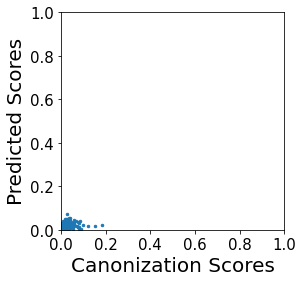

ger xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None
Dropped 300 columns.
train preds: [ 0.02098614  0.01587897  0.08660261 -0.04705691  0.0391637   0.01017671
 -0.02447796  0.06001097  0.01744729  0.01767279  0.07359276 -0.04474692
 -0.00734424 -0.00090756  0.04098172  0.02131221  0.03699194  0.04657308
  0.02519711  0.0255172   0.02347702  0.0670435   0.0104182   0.02793981
 -0.00084549  0.03836377  0.01028252  0.02583779  0.02358955  0.02353446
  0.02237872  0.02795379  0.04507058  0.03896381  0.15087587  0.07970233
 -0.00326446  0.04249138  0.02926717  0.07686114 -0.00585387 -0.01776781
  0.02863795  0.00917782  0.05993377  0.00705379  0.08189898 -0.00033144
  0.02341356  0.04330087  0.04122958  0.01830152  0.00994096  0.01181243
  0.03997741  0.03863993  0.03522161  0.0182693   0.05742586  0.02327265
  0.00910257  0.03138332  0.0579909   0.01649599  0.02733927  0.01291773
  0.01439698  0.00231158  0.03523755  0.01226

train preds: [ 2.28970814e-02  1.62558425e-02  8.63355920e-02  3.90428491e-02
  1.02675082e-02  1.80597827e-02 -2.37756148e-02  1.74605977e-02
  1.79119129e-02  7.34973326e-02 -4.40561175e-02 -7.07164081e-03
 -2.24077172e-04  3.98158804e-02  5.47252633e-02  3.68179157e-02
  2.54787039e-02  2.55667958e-02  1.92250144e-02  2.38529369e-02
  6.67004809e-02  6.06670510e-05  2.92983302e-03  3.83465737e-02
  7.64912227e-03  9.89021175e-03  2.60293111e-02  2.75538824e-02
  9.67572257e-03  2.39811298e-02  3.81651260e-02  2.86191776e-02
  6.82951659e-02  2.78485548e-02  4.34053689e-02  3.85807529e-02
  1.51209325e-01 -2.67129834e-03  2.96796747e-02  7.64456838e-02
 -5.59469406e-03 -1.65344495e-02  2.87128743e-02  5.97692281e-02
  7.18480395e-03  2.72010565e-02  8.44244714e-05  2.30560657e-02
 -1.23499036e-02  4.33670953e-02  4.16142903e-02  3.52901742e-02
  1.81665961e-02  1.08149415e-02  1.00470800e-02  1.16194366e-02
  3.96404155e-02  1.73091274e-02  3.84843089e-02 -4.32780804e-03
  3.48242521

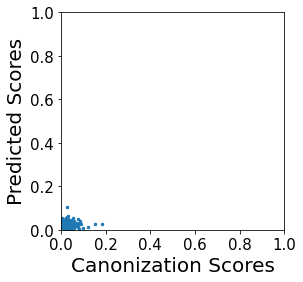

ger xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= None
Dropped 377 columns.
train preds: [ 0.01831675  0.01588058  0.08465952  0.0387701   0.00975659  0.01832152
  0.0601666   0.01839711  0.02095778  0.0725297  -0.0368884  -0.00660255
  0.00039883  0.0380495   0.0211456   0.04485055  0.0259047   0.02749927
  0.01917462  0.02465817  0.06741606  0.01120305  0.00121163  0.03728941
  0.00751021  0.02573775  0.02717736  0.01041204  0.0250846   0.02237201
  0.03756423  0.0296609   0.06820653  0.02665824  0.04282558  0.03899929
  0.14592299  0.07847418  0.02959662  0.07543422 -0.00569388 -0.01715668
  0.02858678  0.00875681  0.05967354  0.00786032  0.02690463  0.08127807
  0.00117799  0.02336258 -0.01022827  0.04256242  0.03477106  0.0196086
  0.01274371  0.01120376  0.01828351 -0.00508249  0.03415662  0.01825508
  0.05281299  0.02386891  0.01067923  0.05803354  0.01542645  0.02740857
  0.01454749 -0.01539343  0.02663742  0.03597

train preds: [ 0.02677135  0.03299679  0.00925787  0.02917701  0.02067878  0.0095777
  0.04876782  0.00063617  0.00834215  0.02670683  0.01771137  0.0234894
  0.02865774  0.02865774  0.02299882  0.0325929   0.02513308  0.02232831
  0.0223992   0.02896983  0.01632876  0.02636535  0.0223992   0.01124425
  0.02784256  0.02670201  0.01848303  0.02832961  0.04589045  0.02456428
  0.0269752   0.02643518  0.05429461  0.04831253  0.00110239  0.04627647
  0.01978296  0.06268395  0.00906076  0.02899328  0.00934341  0.04345438
  0.0578674   0.01329773  0.03950155  0.0223992   0.0181113   0.02421478
  0.03639894  0.01788909  0.00507887  0.0313159   0.01249628  0.03665857
  0.01291272  0.02480577  0.05137046  0.01025607  0.0269752   0.02879078
  0.00344391  0.01755509  0.02040302  0.01776025  0.01650102  0.04128396
  0.01094164  0.05037114  0.01669133  0.0282382   0.07427323  0.03339004
  0.02362675  0.03095661  0.0252254  -0.06090911  0.02005707  0.03047364
  0.02271454  0.03485207  0.02900723  0.

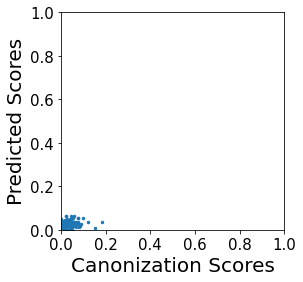

ger xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= None
Dropped 377 columns.
train preds: [ 0.0152624   0.02836082  0.01739924  0.06763947  0.02905417  0.00925569
  0.02201001 -0.01365971  0.0504676   0.02284902  0.05495946 -0.01586321
  0.01478886  0.00251606  0.03767626  0.02551491  0.03587916  0.02160926
  0.01906003  0.02176104  0.04622078  0.01454323  0.02997456  0.00720826
  0.02038922  0.03669606  0.01429225  0.01370546  0.02717832  0.01879516
  0.02248237  0.02538249  0.02647716  0.02906562  0.02814507  0.02997456
  0.03198459  0.09900309  0.05047423  0.00389457  0.0297961   0.06078272
 -0.01253008 -0.00754538  0.02511073  0.00890174  0.04676197  0.01002096
  0.05739462  0.01013825  0.02576403  0.05417395  0.03820435  0.02347488
  0.01882415  0.0095874   0.04161499  0.03202363  0.03136119  0.01578882
  0.04610498  0.02457006  0.01230413  0.02573708  0.05855448  0.01347046
  0.02510501  0.00686675  0.01609824  

train preds: [ 0.01874525  0.02010215  0.01500009  0.03501754  0.0175414   0.01874525
  0.01198696 -0.01179594  0.03181326  0.02330239  0.02398761  0.00986794
  0.01827906  0.01087104  0.01611602  0.02075015  0.03091048  0.02330239
  0.03181326  0.02207703  0.0471501   0.01923165  0.01680124  0.02330239
  0.02593162  0.01568531  0.02491666  0.02914682  0.03479386  0.02853236
  0.03230556  0.04013028  0.02593162  0.02800182  0.04300055  0.02593162
  0.02593162  0.03016661  0.03784889  0.01094741  0.0340127   0.02075015
  0.04863623 -0.00993745  0.04148284  0.02853236  0.04368827  0.0234965
  0.01198696  0.02355485  0.01762933  0.03986696  0.02800182  0.0290266
  0.02773905  0.02593162  0.02435984  0.01500009  0.03297971  0.02593162
  0.02540149  0.01537232  0.04162349  0.02588731  0.0315957   0.01853486
  0.01716314  0.04932145  0.01277265  0.02063871  0.02593162  0.02014498
  0.02784714  0.02398761  0.03986696  0.03323514  0.02330239  0.03014252
  0.0803661   0.03619552  0.02398761  0.

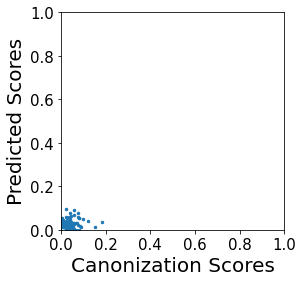

ger xgboost chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= None
Dropped 868 columns.
train preds: [0.03141349 0.02502753 0.02883402 ... 0.02805177 0.0285742  0.03365282]
validation preds: [ 0.0357905   0.02443251  0.02928253  0.02314026  0.01915546  0.01939757
  0.01776391  0.02605229  0.03123221  0.02632958  0.02650267  0.01707792
  0.02826273  0.02466226  0.02858335  0.02615894  0.02256319  0.02637088
  0.02567066  0.01487467  0.02981586  0.01962597  0.02380029  0.02413067
  0.02064993  0.02039373  0.02734591  0.01984127  0.0247063   0.02985945
  0.02824891  0.02563209  0.02576591  0.02059288  0.02461213  0.02368839
  0.02336863  0.01787978  0.02165239  0.01824177  0.02158022  0.02948674
  0.02327636  0.02415769  0.02517249  0.0301822   0.02591565  0.02467176
  0.00440796  0.02621684  0.01810736  0.00375121 -0.02819305  0.00916011
  0.00302006  0.01148287  0.00704927  0.03043964  0.03118279  0.03140791
  0.02917616  0.03046941  0.03474

train preds: [0.01752696 0.02215627 0.01824718 ... 0.02392438 0.01685732 0.02092889]
validation preds: [0.02537949 0.02669342 0.02078923 ... 0.024075   0.02810792 0.02134634]
Fold: 2, TrainMSE: 0.001, TrainMAE: 0.021, ValMSE: 0.001, ValMAE: 0.018, ValR2: -0.069, ValCorr: -0.027
train preds: [0.01722419 0.01969052 0.02296538 ... 0.02556315 0.02531111 0.02811167]
validation preds: [ 0.02242875  0.01780856  0.02350086  0.02434418  0.02244364  0.02888121
  0.02460752  0.01935776  0.01969615  0.01029917  0.0355711   0.02285854
  0.02378127  0.01905064  0.02965228  0.02466971  0.0231335   0.02054306
  0.01947162  0.0314589   0.02713106  0.02433181  0.02218905 -0.00929147
  0.0220547   0.04065986  0.01300511  0.01222518  0.0263024   0.02408246
  0.03119641  0.03711619  0.00192359  0.02610793  0.02727272  0.0208261
  0.02303057  0.02136468  0.03061095  0.02846432  0.03254136  0.03185462
  0.03056083  0.02151422  0.03130522  0.02780215  0.02870869  0.03038376
  0.02542857  0.03038498  0.0264733

train preds: [0.02846195 0.02594312 0.02433503 ... 0.02707277 0.02663754 0.03256231]
validation preds: [ 0.02691602  0.03506306  0.03312141  0.02630586  0.03148279  0.03174013
  0.02352671  0.02453865  0.02757935  0.02750785  0.0300378   0.00933769
  0.00200824  0.01022777 -0.00363643  0.01363941  0.00634329  0.00043474
  0.00913327  0.01498544  0.01486312  0.01360206  0.00373244  0.01081888
  0.02280664  0.01476324  0.01452978  0.021905    0.01201216  0.00766055
  0.00944348  0.01049456  0.01085016  0.02046214  0.00447381  0.0153101
  0.00196066  0.01426505  0.01614645  0.00902592  0.0126868   0.01922824
  0.0166827   0.00453185  0.01257459  0.00696774  0.0114791   0.00842847
  0.01724617  0.01675181  0.0135362   0.0024558   0.0026169   0.01413125
 -0.01400079  0.00644435  0.0086188   0.00919406  0.01530625  0.01026271
  0.00569333  0.0114761   0.02747471  0.00602554  0.00356023  0.02560585
  0.02470401  0.02598007  0.02534759  0.03069191  0.0298442   0.02850136
  0.02766432  0.037356

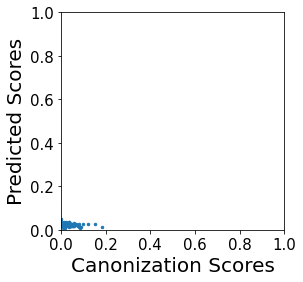

ger xgboost chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None
Dropped 868 columns.
train preds: [0.04489247 0.08612778 0.08245586 ... 0.02842291 0.02431674 0.03273543]
validation preds: [ 2.71179266e-02  1.91448499e-02  2.04707179e-02  2.99300570e-02
  2.23041326e-02  3.64345163e-02  2.65724622e-02  2.01838650e-02
  1.65766794e-02  9.85340867e-03  6.01653606e-02  1.96778178e-02
  2.53589749e-02  2.52748858e-02  2.68681068e-02  3.39235105e-02
  1.87885258e-02  1.52738085e-02  2.40508560e-02  1.39447078e-02
  1.50871975e-02  5.03982464e-03  1.97596904e-02  3.00699361e-02
  2.12305896e-02  1.64120812e-02  2.78923251e-02  2.66414955e-02
  1.56580303e-02  7.16319715e-04  2.94881724e-02  1.84298139e-02
  1.27005540e-02  1.00607518e-02  1.22123770e-02  1.32317757e-02
  1.49866920e-02  1.53803211e-02  2.16325931e-02  1.39314728e-02
  2.08629239e-02  1.54417809e-02  2.00494397e-02  2.03931574e-02
  2.39021257e-02  1.41322389e-02  1.919119

train preds: [0.02444996 0.02729889 0.02342116 ... 0.02406468 0.0263437  0.0295441 ]
validation preds: [ 0.03120236  0.02693382  0.02987688  0.02705083  0.02021061  0.02672708
  0.0241055   0.02332756  0.02273634  0.02505657  0.01988729  0.02234942
  0.02202914  0.02140784  0.01900156  0.02038465  0.03163669  0.02731562
  0.02805796  0.02231357  0.01354415  0.02693382  0.02672708  0.02880637
  0.02880637  0.02783155  0.02894958  0.02330188  0.02861293  0.02584337
  0.02414389  0.02685772  0.02685772  0.02204797  0.02812344  0.02221761
  0.02744446  0.02617873  0.02414389  0.0228966   0.02330188  0.01973518
  0.01905619  0.02486051  0.01902453  0.02775684  0.02879823  0.03021522
  0.03372253  0.03000501  0.02834235  0.03351578  0.02450657  0.03245681
  0.02668261  0.02694701  0.0318713   0.03020234  0.03372253  0.0249676
  0.03051695  0.03166456  0.02557603  0.03351578  0.02995771  0.03351578
  0.03872055  0.02831752  0.02689048  0.02377024  0.03278091  0.02437481
  0.02219944  0.031871

train preds: [0.02350436 0.01876241 0.01933905 ... 0.01971048 0.02091553 0.02042928]
validation preds: [ 8.53239186e-03 -1.01942010e-02  1.16237942e-02 -1.34386886e-02
  1.81707758e-02 -5.21484436e-03 -2.59885099e-02  2.77639925e-03
  7.70477112e-03  1.50956390e-02 -2.35183886e-03 -4.92339954e-03
  6.93888031e-03  2.08482500e-02  4.27415874e-03  5.26465569e-03
  1.13667445e-02  3.09613347e-03 -2.80051213e-03 -4.34532575e-03
  9.23478790e-03  1.62379257e-02  2.11277790e-02 -3.30020976e-03
  1.35438703e-02  8.40827823e-03  1.49704358e-02  1.08364020e-02
 -4.15558135e-03  1.21765165e-02  1.83323994e-02  1.63019020e-02
  2.24825437e-03  1.37481140e-02  4.90447879e-03  1.18709793e-02
  6.51965151e-03  3.94755416e-03  1.41563024e-02  2.06382051e-02
 -4.37704235e-04  3.17582465e-03  1.51435100e-02 -3.74869839e-03
  9.80452518e-04  1.00239888e-02  1.55713186e-02  4.20351746e-03
 -4.75739455e-03  8.71134922e-03  1.83173071e-03  1.53298276e-02
 -1.19466083e-02 -1.69721723e-03  2.39452403e-02  2.

train preds: [0.02500859 0.02135457 0.02612496 ... 0.02603241 0.02243956 0.03028666]
validation preds: [0.0186918  0.02108927 0.01896652 ... 0.0164331  0.03760866 0.00274709]
Fold: 5, TrainMSE: 0.001, TrainMAE: 0.019, ValMSE: 0.001, ValMAE: 0.02, ValR2: -0.0, ValCorr: 0.076
TrainMSE: 0.0, TrainRMSE: 0.018, TrainMAE: 0.012, TrainR2: 0.676, TrainCorr: 0.863, ValMSE: 0.001, ValRMSE: 0.036, ValMAE: 0.026, ValR2: -0.195, ValCorr: -0.134, ValCorrPValue: 0.091

---------------------------------------------------



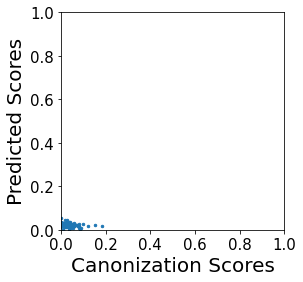

ger xgboost chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= None
Dropped 868 columns.
train preds: [0.02036927 0.02028792 0.018549   ... 0.02826119 0.02514523 0.03607377]
validation preds: [ 0.02526377  0.03781433  0.02606702  0.02960371  0.02597269  0.03133858
  0.02384669  0.02570872  0.02605928  0.03176337  0.04318403  0.03791731
  0.02417467  0.01817201  0.03025041  0.01994979  0.02657715  0.02424944
  0.02351216  0.02706299  0.02296437  0.02478306  0.02416611  0.02657861
  0.02389143  0.02396686  0.02828924  0.02671315  0.03165795  0.02721957
  0.0253431   0.02231031  0.02308843  0.02567573  0.02712165  0.02686388
  0.02850471  0.02424583  0.02670309  0.02948093  0.02095996  0.02425502
  0.02343211  0.02832097  0.02306399  0.03205722  0.03479972  0.02594931
  0.03247071  0.02637986  0.03022692  0.03014505  0.02973185  0.0326768
  0.03708598  0.03273441  0.03136509  0.02494277  0.041414    0.03257213
  0.03105989  0.02472415  0

train preds: [0.02381791 0.02196373 0.02438845 ... 0.02619733 0.02625851 0.02876938]
validation preds: [ 0.02661901  0.02432423  0.02690148  0.02745249  0.0281454   0.02975555
  0.0261133   0.02692476  0.02285753  0.02369648  0.0308195   0.02714837
  0.02653296  0.02403917  0.02859294  0.02721984  0.03374522  0.02742898
  0.02822174  0.0246172   0.02224664 -0.01729522  0.02261474  0.03327146
  0.01581542  0.00976739  0.02882204  0.00784485  0.05273592  0.03290359
 -0.00889235  0.04745606  0.02158908  0.01545727  0.02511741  0.01614988
  0.02533658  0.02537431  0.01629998  0.00730861  0.02950162  0.02699131
  0.02634404  0.0266797   0.02930167  0.02983773  0.02694102  0.02485069
  0.02586678  0.02419138  0.02293481  0.02348623  0.02586961  0.02426691
  0.02765095  0.02670418  0.02622312  0.02565208  0.02617195  0.02802256
  0.02879051  0.02917212  0.0256513   0.02802384  0.02675012  0.02321489
  0.02585378  0.02738019  0.02750021  0.02546258  0.02694102  0.02814629
  0.02759689  0.02753

train preds: [0.02822614 0.02131188 0.02181518 ... 0.01863403 0.00971695 0.01867076]
validation preds: [ 0.02221913  0.01663319  0.02194526  0.01719231  0.01616658  0.00590991
  0.01273168  0.01700226  0.01569747  0.01342682  0.0155787   0.02052425
  0.00905743  0.01065905  0.02032597  0.01488622  0.01015792  0.01007408
  0.01390021  0.01399796  0.01641644  0.01764481  0.02021408  0.01562866
  0.01923359  0.01948428  0.02020395  0.01756877  0.020162    0.0122214
  0.02412409  0.01575236  0.01541161  0.01742831  0.00767415  0.01656101
  0.00952794  0.01695413  0.02002171  0.02217758  0.00794212  0.01754563
  0.01762755  0.014782    0.01783607  0.02184664  0.01980795  0.00869983
  0.01963974  0.01644646  0.01800001  0.02781125  0.02414593  0.02307416
  0.02579668  0.02562442  0.02111802  0.02977998  0.0169123   0.01721984
  0.02711536  0.02318746  0.02328793  0.02173598  0.0167239   0.02048951
  0.01961952  0.0140273   0.02677     0.02509777  0.01882427  0.02092936
  0.01375726  0.017346

train preds: [0.02565122 0.02400148 0.02369925 ... 0.02942271 0.02714841 0.02755773]
validation preds: [0.01646599 0.01407566 0.01118738 0.00978437 0.02067328 0.01513593
 0.00846828 0.01304873 0.01428511 0.00846828 0.0137681  0.00985661
 0.02355696 0.02292976 0.02196314 0.0235546  0.02908713 0.02981907
 0.02552308 0.03168386 0.02303523 0.02400571 0.02416    0.02862631
 0.02551881 0.03118402 0.02399318 0.02839176 0.02190264 0.02902211
 0.02317615 0.02397125 0.02638322 0.02332259 0.01837055 0.02776584
 0.02718049 0.03064241 0.03137988 0.02249015 0.01817345 0.02678928
 0.02140316 0.02471897 0.02871513 0.02930213 0.02388343 0.03023803
 0.02328558 0.02500789 0.020481   0.02029127 0.02232695 0.02326357
 0.02574843 0.02152492 0.02094983 0.02993601 0.02785204 0.02347932
 0.02965089 0.02382693 0.023082   0.02310494 0.0257559  0.0192352
 0.02940847 0.02199102 0.0283059  0.02613142 0.02142564 0.02345364
 0.02743282 0.02345472 0.02242939 0.02772525 0.02382083 0.02863412
 0.02279607 0.02045954 0.02

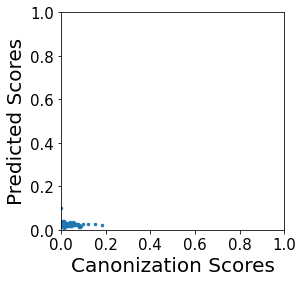

ger xgboost chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= None
Dropped 868 columns.
train preds: [0.02698897 0.02526188 0.01871106 ... 0.02776729 0.02057437 0.03235389]
validation preds: [ 0.03834365  0.02858956  0.02952309  0.01811209  0.01216425  0.00069281
  0.01427786  0.02399321  0.01501221  0.01648517  0.02770125  0.02062449
  0.01827855  0.00088764  0.02079885  0.01666351  0.01606675  0.00228504
  0.01944341  0.02490311  0.02037411  0.00993792  0.02929321  0.01602417
  0.01711599  0.02211035  0.02105003  0.01915026  0.02491177  0.01624739
  0.0219192   0.0094692   0.01428307  0.03383722  0.00696588  0.02361912
  0.02104136  0.03236473  0.02788744  0.03560428  0.01068195  0.01860583
  0.02294818  0.03796228  0.02847974  0.02479063  0.02178676  0.02494082
  0.01991815  0.03686691  0.02384573  0.02579601  0.0276794   0.03325286
  0.02117075  0.02328773  0.02598089  0.03396472  0.04151079  0.03370425
  0.02861617  0.0323

train preds: [0.02347631 0.022445   0.0255026  ... 0.02558785 0.02484548 0.02735736]
validation preds: [0.0248202  0.02112004 0.014984   ... 0.0363139  0.01109419 0.01791159]
Fold: 3, TrainMSE: 0.001, TrainMAE: 0.022, ValMSE: 0.001, ValMAE: 0.018, ValR2: -0.096, ValCorr: 0.122
train preds: [0.02733658 0.02142805 0.0214402  ... 0.01288819 0.01534311 0.02377762]
validation preds: [ 0.02002743  0.02147972  0.0177679   0.02349335  0.01984463  0.01577899
  0.01972776  0.02063804  0.02523796  0.02365184  0.01631014  0.00930466
  0.00548184  0.0202971   0.02225496  0.02270037  0.00770635  0.02124669
  0.02686029  0.02246928  0.01951433  0.02831881  0.02893001  0.03050881
  0.0272288   0.01963156  0.02463394  0.01803254  0.01712926  0.0222234
  0.02024139  0.01722864  0.02118434  0.01617419  0.01918036  0.02274283
  0.02092892  0.01029725  0.02115337  0.01281067  0.01819519  0.02108135
  0.0228656   0.02816025  0.01847768  0.01902716  0.02508171  0.01567209
  0.01755011  0.01651269  0.01811503

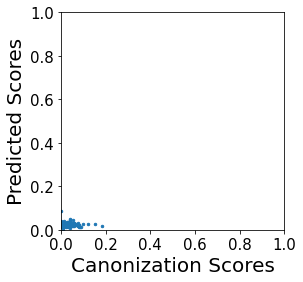

ger xgboost book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= None
Dropped 1168 columns.
train preds: [ 2.04855446e-02  1.61219947e-02  8.66339281e-02 -4.63943928e-02
  3.88086624e-02  1.05120782e-02  1.80254839e-02  5.97826205e-02
  1.73538979e-02  1.82585362e-02  7.29517788e-02 -7.26079289e-03
 -1.07194704e-03  4.11068238e-02  2.07399298e-02  3.67657915e-02
  4.63744290e-02  1.98078100e-02  6.64194822e-02  1.04542449e-02
  2.80123577e-02 -3.73911404e-04  3.87391672e-02  7.66295986e-03
  9.67937242e-03  2.58206185e-02  2.75422074e-02  9.79226734e-03
  2.44396944e-02  2.40320675e-02  2.23736353e-02  3.80065553e-02
  2.81511378e-02  6.82504028e-02  4.50743511e-02  3.85480635e-02
  1.51833773e-01  7.90081695e-02 -2.98800529e-03  4.22250144e-02
  2.92710140e-02  7.71952569e-02 -5.48895774e-03 -1.67350750e-02
  5.91815300e-02  7.23601924e-03  2.69424729e-02  8.19339752e-02
  4.32792343e-02  4.20058519e-02  3.52313481e-02  1.82

train preds: [ 2.0564780e-02  2.2807416e-02  8.6559258e-02 -4.6134938e-02
  1.0331089e-02  1.8099584e-02 -2.4336819e-02  6.0362838e-02
  1.7671186e-02  7.3475495e-02 -4.4272304e-02 -7.1205925e-03
 -5.8788026e-04  4.0658228e-02  5.4650508e-02  3.6923204e-02
  2.5366066e-02  2.5269173e-02  1.9832475e-02  2.3604486e-02
  1.0631320e-02  2.7877076e-02 -5.8370654e-04  3.1807043e-03
  3.8582712e-02  7.6795383e-03  9.8826699e-03  2.6087673e-02
  2.7001109e-02  9.3773063e-03  2.4123378e-02  2.3986140e-02
  2.2400284e-02  3.7941396e-02  2.8713671e-02  6.8110779e-02
  2.7692400e-02  4.4721331e-02  3.8923297e-02  1.5125377e-01
  7.9199791e-02 -2.7048888e-03  4.2435162e-02  7.7089630e-02
 -1.6496131e-02  2.8622784e-02  9.5984433e-03  7.0226942e-03
  2.6932117e-02  8.2139283e-02 -3.1697680e-04  2.3923887e-02
 -1.2372190e-02  4.3705143e-02  4.2083900e-02  3.5424899e-02
  1.8668152e-02  1.0343295e-02  3.9686315e-02  1.7665133e-02
  3.8874693e-02 -4.5708558e-03  1.8426541e-02  2.3644729e-02
  9.3852831

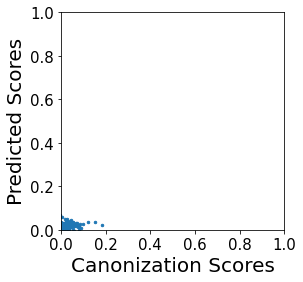

ger xgboost book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None
Dropped 1168 columns.
train preds: [ 2.07942184e-02  1.64585225e-02  8.65470842e-02 -4.09303047e-02
  1.02410335e-02  1.89190935e-02 -2.30376683e-02  6.02979623e-02
  1.75171457e-02  1.85596664e-02 -4.34146710e-02 -2.11627615e-04
  2.12735217e-02  3.69668007e-02  4.62038070e-02  2.56605111e-02
  2.54170913e-02  2.06075832e-02  1.08170770e-02  2.79723648e-02
  3.75408540e-03  3.86352800e-02  8.15650448e-03  1.02571370e-02
  2.62853894e-02  2.75647547e-02  9.59029514e-03  2.38872487e-02
  2.41076164e-02  2.30730623e-02  3.82734574e-02  2.86631882e-02
  6.83445036e-02  2.78403293e-02  4.54915911e-02  3.86888050e-02
  7.93191195e-02 -2.35451316e-03  4.24473397e-02  7.71309584e-02
 -4.85948008e-03  2.88032293e-02  9.65881534e-03  5.98939843e-02
  7.68499821e-03  2.72939242e-02  8.18103254e-02  1.10697700e-03
 -1.08670481e-02  4.20359708e-02  3.55004631e-02

train preds: [ 2.0911740e-02  2.2626577e-02  1.5938491e-02  8.6481653e-02
 -4.6705186e-02  3.8871679e-02  1.0334817e-02  1.7966047e-02
 -2.4275623e-02  6.0154371e-02  1.7419739e-02  1.8223962e-02
  7.3388025e-02 -4.4832412e-02 -7.1557718e-03 -1.3054397e-03
  4.0605303e-02  5.4743081e-02  3.7003785e-02  2.5014261e-02
  2.5364622e-02  2.3573115e-02  6.6985048e-02  2.7831344e-02
 -9.7906962e-04  3.8404405e-02  7.5875153e-03  9.9918544e-03
  2.5860075e-02  2.3621894e-02  2.2468487e-02  2.8766839e-02
  2.7358864e-02  4.5021072e-02  3.8572073e-02  1.5129256e-01
 -3.1955114e-03  4.2393308e-02  2.9310528e-02  7.6841258e-02
 -5.8401641e-03 -1.6866997e-02  2.8452795e-02  5.9420865e-02
  7.1288235e-03  8.2262121e-02  2.3330098e-02 -1.2741556e-02
  4.3581802e-02  4.1968286e-02  1.8288383e-02  1.0014924e-02
  1.1972350e-02  3.9789379e-02  1.7750932e-02  3.8625199e-02
 -4.9464232e-03  3.4698475e-02  1.8175373e-02  2.3351120e-02
  9.3835527e-03  3.1205745e-02  5.8320705e-02  2.6562762e-02
  1.3079936

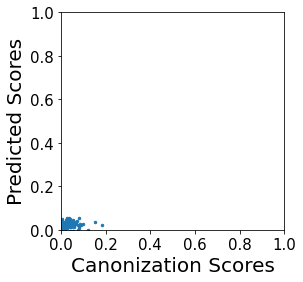

ger xgboost book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= None
Dropped 1245 columns.
train preds: [ 0.02019394  0.02309482  0.01601479  0.08508397  0.03683839  0.01358795
  0.01928257 -0.02204159  0.05967778  0.01912307  0.02059261  0.07233511
 -0.03916172 -0.00493883  0.00238916  0.0402364   0.021525    0.03694957
  0.04528267  0.02621024  0.02604065  0.06659093  0.01109502  0.02811887
  0.00076836  0.00507625  0.00940447  0.00962786  0.02538719  0.02616358
  0.02410206  0.02429086  0.03779571  0.02809837  0.02765395  0.0424363
  0.03789731  0.14436843  0.07807543  0.00148094  0.03159482  0.07606799
 -0.0044134  -0.01502551  0.02906307  0.01068001  0.05828275  0.00875431
  0.08170506  0.04358782  0.04212296  0.01935554  0.01402343  0.01213921
  0.01379663  0.03972542  0.03872449 -0.0031206   0.03457421  0.01969422
  0.055427    0.02565868  0.01007496  0.05667753  0.01666857  0.01205226
  0.02679449  0.01253165 

train preds: [ 0.01970884  0.02262978  0.0158535   0.08536112 -0.03667086  0.03734586
  0.01211985  0.02051963 -0.02262718  0.01803442  0.0217861   0.02118344
  0.05309719  0.03673593  0.04455717  0.02727019  0.02624905  0.02192906
  0.0240887   0.0640111   0.02766204  0.03785637  0.00896375  0.02781486
  0.01121542  0.02351287  0.02750125  0.02370615  0.02895851  0.06791803
  0.03767321  0.07915072 -0.00125872  0.04263679  0.03006237  0.0777024
 -0.00496618  0.02891632  0.00994723  0.0088228   0.02781202  0.07913259
  0.00073402  0.02413942 -0.00937971  0.03571475  0.01897156  0.00929514
  0.01169453  0.0395685   0.01808912  0.03476053  0.05442652  0.02440555
  0.00982453  0.03014391  0.05746071  0.01682713  0.010785    0.02669846
  0.01332667  0.01361829 -0.01370596  0.00308885  0.02669733  0.0126919
  0.01325824  0.05408568  0.12020157  0.01281323  0.03734939  0.02211026
  0.00198306  0.05889888  0.02249317  0.03166774  0.05410087  0.01316545
  0.0364299  -0.01868756 -0.04398679  0.

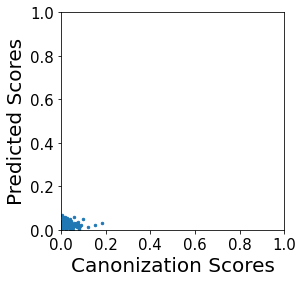

ger xgboost book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= None
Dropped 1245 columns.
train preds: [ 2.06749998e-02  2.30203085e-02  1.59989074e-02  8.65352377e-02
  3.84697802e-02  1.80316959e-02 -2.39043217e-02  1.75069440e-02
  1.79258902e-02  7.34826103e-02 -4.49957959e-02 -6.95289252e-03
 -1.46566622e-03  4.00571227e-02  5.40783033e-02  3.71814817e-02
  2.51827966e-02  2.51608565e-02  1.96657591e-02  6.72977790e-02
  1.06830951e-02  2.75791269e-02 -5.90498152e-04  4.01500333e-03
  3.84318233e-02  7.60007650e-03  9.59128048e-03  2.60619335e-02
  2.69040223e-02  9.63135436e-03  2.48271208e-02  2.36959402e-02
  2.25502849e-02  3.84044535e-02  2.86974590e-02  6.79645240e-02
  2.76584513e-02  4.55954447e-02  3.86326052e-02  1.49946511e-01
  7.89884850e-02 -2.90059648e-03  2.90802754e-02  7.67235830e-02
 -5.66964131e-03 -1.73922423e-02  2.85643935e-02  9.39434208e-03
  5.97947240e-02  7.83165358e-03  2.71449

train preds: [ 2.04008818e-02  2.30410565e-02 -4.56774794e-02  1.05271367e-02
  1.80450100e-02 -2.44357400e-02  6.03051186e-02  1.84787363e-02
  7.34767690e-02 -4.42544445e-02 -6.82605291e-03 -1.41921826e-03
  4.06775400e-02  2.09915023e-02  5.42547964e-02  3.72520201e-02
  4.62337546e-02  2.55384054e-02  2.53781024e-02  1.95398349e-02
  2.38428432e-02  1.06329517e-02  2.79491674e-02 -9.79398959e-04
  3.82334143e-02  7.49489199e-03  9.83888097e-03  2.60473937e-02
  2.40561534e-02  2.40847375e-02  2.29073707e-02  2.86270995e-02
  6.80909529e-02  2.74884310e-02  3.85903902e-02  1.50434479e-01
  7.88821504e-02 -3.36294365e-03  4.24795225e-02  7.62160793e-02
 -1.68568566e-02  2.87144240e-02  9.54975933e-03  7.09080743e-03
  2.68978998e-02  8.22894424e-02 -3.97102325e-04  2.31397655e-02
  4.36185040e-02  4.19928320e-02  3.54506895e-02  3.94914858e-02
  3.83698046e-02 -4.55860421e-03  1.83921196e-02  5.66887856e-02
  2.37545688e-02  9.39843245e-03  3.06714997e-02  1.63727906e-02
  9.79322661

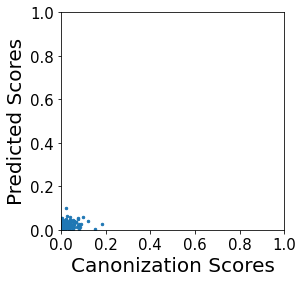

ger xgboost chunk_and_copied_book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= None
Dropped 1168 columns.
train preds: [0.01128898 0.01128898 0.01128898 ... 0.02299821 0.02299821 0.02299821]
validation preds: [ 0.04338624  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624
  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624
  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624
  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624
  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624
  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624
  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624
  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624
  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624  0.04338624
  0.01174204  0.01174204  0.01174204  0.01972092  0.01972092  0.01972092
  0.01972092  0.

train preds: [0.01894779 0.01894779 0.01894779 ... 0.02848273 0.02848273 0.02848273]
validation preds: [ 0.00746259  0.00746259  0.00746259  0.00746259  0.00746259  0.00746259
  0.00746259  0.00746259  0.00746259  0.00746259  0.00746259  0.00746259
  0.00746259  0.01352703  0.01352703  0.01352703  0.01352703  0.01352703
  0.01352703  0.01352703  0.01352703  0.01352703  0.01352703  0.01352703
  0.01352703  0.01352703 -0.0018967  -0.0018967  -0.0018967  -0.0018967
 -0.0018967   0.02518435  0.02518435  0.02518435  0.02518435  0.02518435
  0.02518435  0.02518435  0.02518435  0.02518435  0.02518435  0.02518435
  0.02441692  0.02441692  0.02441692  0.02441692  0.02441692  0.02441692
  0.02441692  0.02441692  0.02441692  0.02441692  0.02441692  0.02441692
  0.02441692  0.02441692  0.02441692  0.02441692  0.02441692  0.02441692
  0.02441692  0.02441692  0.02441692  0.02441692  0.02441692  0.02441692
  0.02441692  0.02441692  0.02441692  0.02441692  0.02441692  0.02441692
  0.02441692  0.024416

train preds: [0.02270962 0.02270962 0.02270962 ... 0.03069371 0.03069371 0.03069371]
validation preds: [0.02491149 0.02491149 0.02491149 ... 0.01954472 0.01954472 0.01954472]
Fold: 3, TrainMSE: 0.0, TrainMAE: 0.011, ValMSE: 0.001, ValMAE: 0.018, ValR2: -0.098, ValCorr: 0.098
train preds: [0.02107354 0.02107354 0.02107354 ... 0.02156765 0.02156765 0.02156765]
validation preds: [ 0.02599474  0.02599474  0.02635976  0.02599474  0.02599474  0.02599474
  0.02594359  0.02594359  0.02599474  0.02599474  0.02599474  0.0392612
  0.0392612   0.0392612   0.0392612   0.0392612   0.0392612   0.0392612
  0.0392612   0.0392612   0.0392612   0.0392612   0.0392612   0.0392612
  0.0392612   0.0392612   0.0392612   0.0392612   0.02305748  0.02305748
  0.02305748  0.02305748  0.02305748  0.02305748  0.02305748  0.02305748
  0.02305748  0.02305748  0.02305748  0.02305748  0.02305748  0.02305748
  0.02305748  0.02305748  0.02305748  0.02305748  0.02305748  0.0160251
  0.0160251   0.0160251   0.0160251   0.0

train preds: [0.02306126 0.02306126 0.02306126 ... 0.0390311  0.0390311  0.0390311 ]
validation preds: [ 7.1168400e-02  7.1168400e-02  7.1168400e-02  7.1168400e-02
  7.1168400e-02  7.1168400e-02  7.1168400e-02  7.1168400e-02
  7.1168400e-02  7.1168400e-02  7.1168400e-02  7.1168400e-02
  7.1168400e-02  7.1168400e-02  7.1168400e-02  7.1168400e-02
  2.9337643e-02  2.9337643e-02  2.7767971e-02  2.7767971e-02
  2.0702805e-02  2.0702805e-02  2.0702805e-02  2.0702805e-02
  2.8777009e-02  2.8777009e-02  3.2536410e-02  2.8777009e-02
  2.8777009e-02  2.8777009e-02  5.1654540e-02  5.1309202e-02
  5.1654540e-02  5.1309202e-02  5.1309202e-02  5.1309202e-02
  5.1654540e-02  5.1309202e-02  5.1309202e-02  5.1309202e-02
  5.1654540e-02  5.1654540e-02  5.1654540e-02  5.1309202e-02
  5.1309202e-02  5.1309202e-02  5.1654540e-02  5.0160222e-02
  5.1654540e-02  5.1654540e-02  5.1654540e-02  5.1654540e-02
  5.1654540e-02  5.1309202e-02  5.1654540e-02  5.1309202e-02
  5.1654540e-02  5.1654540e-02  5.1309202e-

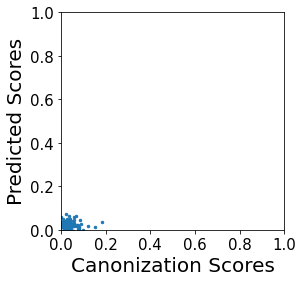

ger xgboost chunk_and_copied_book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None
Dropped 1168 columns.
train preds: [0.02192353 0.02192353 0.02192353 ... 0.02971187 0.02971187 0.02971187]
validation preds: [ 0.02033036  0.02033036  0.02033036  0.02033036  0.02033036  0.02033036
  0.02033036  0.02033036  0.02033036  0.02033036  0.02033036  0.02970025
  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025
  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025
  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025
  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025
  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025
  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025
  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025
  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025  0.02970025
  0.029700

train preds: [0.02108235 0.02108235 0.02108235 ... 0.03247638 0.03247638 0.03247638]
validation preds: [ 0.01370354  0.01370354  0.01370354  0.01370354  0.01370354  0.01370354
  0.01370354  0.01370354  0.01370354  0.01370354  0.01370354  0.01370354
  0.01370354  0.01370354  0.01370354  0.01370354 -0.01628061 -0.01628061
 -0.00156458 -0.00156458 -0.00156458 -0.00156458 -0.00156458  0.02648621
  0.02648621  0.02648621  0.02648621  0.02648621  0.02648621  0.02648621
  0.02648621  0.02648621  0.02648621  0.02648621  0.01276772  0.01276772
  0.01276772  0.01276772  0.01276772  0.01276772  0.01276772  0.01276772
  0.01276772  0.01276772  0.01276772  0.01276772  0.01276772  0.01276772
  0.01276772  0.01276772  0.01276772  0.01276772  0.01276772  0.01276772
  0.01276772  0.01276772  0.01276772  0.01276772  0.01276772  0.01276772
  0.01276772  0.01276772  0.01511693  0.01511693  0.01511693  0.01511693
  0.01511693  0.01511693  0.01511693  0.01511693  0.01511693  0.01511693
  0.01511693  0.01511

train preds: [0.01974071 0.01974071 0.01974071 ... 0.02184369 0.02184369 0.02184369]
validation preds: [ 0.05932092  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092
  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092
  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092
  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092
  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092
  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092
  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092
  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092  0.05932092
  0.02503231  0.02503231  0.02503231  0.02503231  0.02503231  0.02503231
  0.02503231  0.02503231  0.02503231  0.02503231  0.02402337  0.02503231
  0.02503231  0.02402337  0.02402337  0.02503231  0.02503231  0.02503231
  0.02503231  0.02503231  0.02503231  0.02503231  0.02503231  0.02503231
  0.02503231  0.02503

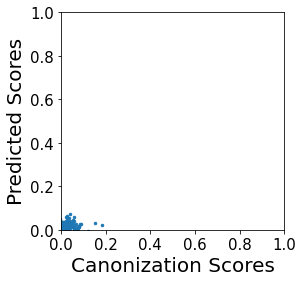

ger xgboost chunk_and_copied_book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= None
Dropped 1245 columns.
train preds: [0.01508218 0.01508218 0.01508218 ... 0.02118402 0.02118402 0.02189731]
validation preds: [0.00937169 0.01172618 0.00980755 ... 0.00944025 0.01023934 0.01027342]
Fold: 1, TrainMSE: 0.0, TrainMAE: 0.012, ValMSE: 0.001, ValMAE: 0.028, ValR2: -0.216, ValCorr: -0.011
train preds: [0.0205549  0.0205549  0.0205549  ... 0.03887818 0.03887818 0.03887818]
validation preds: [ 0.01792904  0.01792904  0.01789671  0.01789671  0.01789671  0.01792904
  0.01812731  0.01798229  0.01792904  0.01789671  0.01792904  0.0455577
  0.0455577   0.0455577   0.04509507  0.0455577   0.04532715  0.04524854
  0.0455577   0.04509507  0.0455577   0.0455577   0.0455577   0.0455577
  0.0455577   0.04524854  0.0455577   0.0455577   0.0455577   0.0455577
  0.03593698  0.03537811  0.03413928  0.03413928  0.03509439  0.03252596
  0.03263002  0.03243639  0

train preds: [0.01898677 0.0188527  0.01898677 ... 0.03743269 0.03782981 0.03743269]
validation preds: [ 0.03450993  0.0368597   0.0368597   0.0368597   0.0341556   0.03335166
  0.03349446  0.03345807  0.03521267  0.0341556   0.03349446  0.03615999
  0.03065197  0.03521267  0.03521267  0.03672303  0.0341556   0.03609147
  0.03335166  0.03521267  0.02999215  0.02893508  0.02999215  0.02999215
  0.02893508  0.02999215  0.02853796  0.02999215  0.02999215  0.02893508
  0.02999215  0.02893508  0.02956665  0.03150252  0.02999215  0.03012622
  0.02999215  0.02999215  0.02893508  0.03012622  0.02999215  0.02893508
  0.02999215  0.02999215  0.02853796  0.02797806  0.02784399  0.02797806
  0.02797806  0.02279715  0.02797806  0.02862586  0.02862586  0.02447443
  0.02797806  0.02447443  0.02797806  0.03127698  0.02797806  0.04623183
  0.04679529  0.05120171  0.04573823  0.04679529  0.04493428  0.04679529
  0.04767409  0.04679529  0.04679529  0.04493428  0.04493428  0.04767409
  0.04692936  0.05063

train preds: [0.02292344 0.02292344 0.0232319  ... 0.03673223 0.03925938 0.03929505]
validation preds: [ 0.02308854  0.02308854  0.02345402  0.02308854  0.02244995  0.02308854
  0.02308854  0.02308854  0.02308854  0.02244995  0.02281542  0.02308854
  0.02281542  0.02281542  0.02345402  0.02345402  0.02103223  0.02077779
  0.02077779  0.02057435  0.02072168  0.02126828  0.02057435  0.02077779
  0.02085239  0.02075645  0.02066321  0.02049093  0.02058184  0.02044045
  0.02083987  0.02100636  0.02061768  0.02061768  0.02061768  0.02057435
  0.02061768  0.02048219  0.02069708  0.02083987  0.02139615  0.02133407
  0.02133407  0.02133407  0.02066321  0.02072234  0.02048219  0.02076459
  0.02064272  0.02083987  0.02077779  0.02076525  0.02044635  0.02075686
  0.02126828  0.020888    0.02082223  0.020888    0.02068456  0.02133713
  0.02074805  0.02090565  0.02144057  0.02060114  0.02057435  0.02090565
  0.02077779  0.02083323  0.02095008  0.02068456  0.02653394  0.02640783
  0.02640783  0.02773

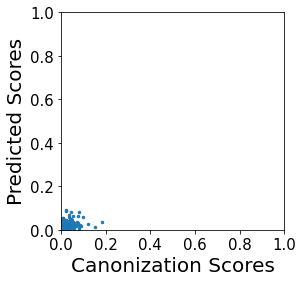

ger xgboost chunk_and_copied_book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= None
Dropped 1245 columns.
train preds: [0.02070317 0.02077524 0.02083874 ... 0.03866428 0.03936164 0.03930528]
validation preds: [ 0.0358381   0.03324114  0.03548459  0.03550576  0.03649604  0.03290524
  0.03547758  0.03578321  0.03346436  0.03578321  0.0361904   0.0358381
  0.03603115  0.03633679  0.03649604  0.03644502  0.0361786   0.03524472
  0.03594387  0.03529574  0.03529574  0.03578644  0.03342307  0.03578321
  0.03383758  0.03319999  0.03370573  0.03649101  0.03618538  0.03578321
  0.03578708  0.03313153  0.03573219  0.03578321  0.03578321  0.03578644
  0.03644502  0.03578644  0.03598262  0.03620244  0.03649604  0.03649604
  0.03676605  0.03273322  0.03578708  0.03583745  0.03727829  0.03596703
  0.03524539  0.03578321  0.03649604  0.03649101  0.03649604  0.03621158
  0.01851546  0.01844898  0.05605609  0.05567358  0.05606484  0.05531313
  0.

train preds: [0.02315837 0.02311684 0.02311684 ... 0.0392342  0.0392342  0.0392342 ]
validation preds: [ 1.29028503e-02  1.29028503e-02  1.29028503e-02  1.29028503e-02
  1.29028503e-02  1.29028503e-02  1.29028503e-02  1.29028503e-02
  1.29028503e-02  1.29028503e-02  1.25419553e-02  1.29028503e-02
  1.29028503e-02  1.29028503e-02  1.24985250e-02  1.29028503e-02
  2.59374157e-02  2.59368327e-02  2.59368327e-02  2.59368327e-02
  2.58954130e-02  2.58954130e-02  2.59368327e-02  2.59368327e-02
  2.59368327e-02  2.58954130e-02  2.59775482e-02  1.71057899e-02
  1.71057899e-02  1.71057899e-02  1.72087178e-02  1.71472095e-02
  1.72087178e-02  1.71472095e-02  1.71472095e-02  1.72087178e-02
  1.71472095e-02  1.71472095e-02  1.71472095e-02  1.71472095e-02
  1.61747318e-02  1.71472095e-02  1.71472095e-02  1.61747318e-02
  1.61747318e-02  1.71472095e-02  4.21303883e-02  4.21303883e-02
  4.21303883e-02  3.86730321e-02  1.87659096e-02  1.72334518e-02
  1.72334518e-02  1.72334518e-02  1.71920322e-02  1.

train preds: [0.01404154 0.01404154 0.01285888 ... 0.01090622 0.00972356 0.00972356]
validation preds: [ 3.2760254e-03  3.2760254e-03  3.2760254e-03  3.2760254e-03
  3.2760254e-03  3.2760254e-03  3.2760254e-03  3.2760254e-03
  3.2760254e-03  3.2760254e-03  3.2760254e-03  3.2760254e-03
  3.2760254e-03  3.2760254e-03  3.2760254e-03  3.2760254e-03
  3.2760254e-03  3.2760254e-03  3.2760254e-03  3.2760254e-03
  3.2760254e-03 -1.0554756e-03  3.2760254e-03  3.2760254e-03
  3.2760254e-03  3.2760254e-03  3.2760254e-03  3.2760254e-03
  3.2760254e-03  3.2760254e-03  3.2760254e-03  3.2760254e-03
  3.2760254e-03  3.2760254e-03  3.2760254e-03  3.2760254e-03
  3.2760254e-03  3.2760254e-03  3.2760254e-03  3.2760254e-03
  3.2760254e-03  3.2760254e-03  3.2760254e-03  3.2760254e-03
  3.2760254e-03  3.2760254e-03 -1.0554756e-03 -1.0554756e-03
  1.7153561e-02  1.8336223e-02  1.7153561e-02  1.7153561e-02
  1.8645046e-02  1.7153561e-02  1.7153561e-02  1.9827709e-02
  1.9827709e-02  1.8336223e-02  1.7153561e-

train preds: [0.02005474 0.02005474 0.02005474 ... 0.0353095  0.03653785 0.04001927]
validation preds: [ 0.02583028  0.03128145  0.02633478  0.02651589  0.02495804  0.03512853
  0.02632523  0.02608242  0.02476739  0.02589176  0.02455124  0.03575266
  0.02589176  0.03512853  0.02457084  0.03221205  0.0291935   0.03211197
  0.03014194  0.02988638  0.0160379   0.01584724  0.01478338  0.01496622
  0.01628234  0.01528662  0.01660755  0.01655377  0.01472178  0.01557939
  0.01655377  0.00702641  0.00715244  0.00715244  0.00715244  0.01072706
  0.00749593  0.00715244  0.0073431   0.0073431   0.0073431   0.00715244
  0.00749593  0.00799751  0.00737339  0.01896218  0.01994162  0.01903361
  0.01877152  0.01835455  0.01819389  0.01777608  0.01822883  0.01918933
  0.01877152  0.01797774  0.01791142  0.01832923  0.01792242  0.01792242
  0.02030427  0.01820523  0.01820523  0.01918933  0.01726288  0.01791142
  0.01877152  0.01819389  0.01930977  0.01832923  0.01947214  0.01877152
  0.01808479  0.01877

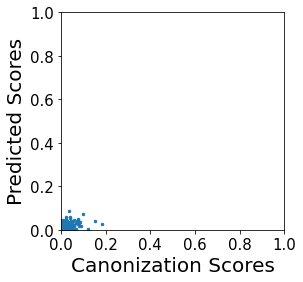

In [14]:
'''
Run Regression
'''
results = []
param_dict = "regression" 
for lang in [lang]:
    if param_dict == "regression":
        param_dir = regression_params
    if param_dict == "testing":
        param_dir = testing_params
    elif param_dict == "multiclass":
        param_dir = multiclass_params
    elif param_dict == "full_cv":
        param_dir = full_cv_params
    elif param_dict == "language_specific":
        if lang == "eng":
            param_dir = eng_params
        else: 
            param_dir = ger_params
    
    #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
    book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
    book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
    chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
    chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")

    for model in param_dir['model']:
        model_param = model_params[model]
        for model_param in model_param:
            for dimensionality_reduction in param_dir["dimensionality_reduction"]:
                for features in param_dir["features"]:
                    for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]: 
                        print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
                        experiment = Regression(
                            language=lang,
                            features=features,
                            drop_columns_including=drop_columns_including,
                            dimensionality_reduction=dimensionality_reduction,
                            model_param=model_param,
                            model=model,
                            verbose=True
                        )
                        mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value = experiment.run()
                        results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value))
                        #except Exception as e:
#                             print(f"Error in {lang}, {model}, {features}, {drop_columns_including}, {dimensionality_reduction}")
#                             print(e)
results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
"dimensionality_reduction", "model_param", "mean_train_mse", "mean_train_rmse", 
"mean_train_mae", "mean_train_r2", "mean_train_corr", "mean_validation_mse", "mean_validation_rmse",
"mean_validation_mae", "mean_validation_r2", "mean_validation_corr", "mean_p_value"])
results_df.to_csv(results_dir + lang + '_' + 'regression_' + senti_tool + param_dict + ".csv", index=False)